Path found: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10)]


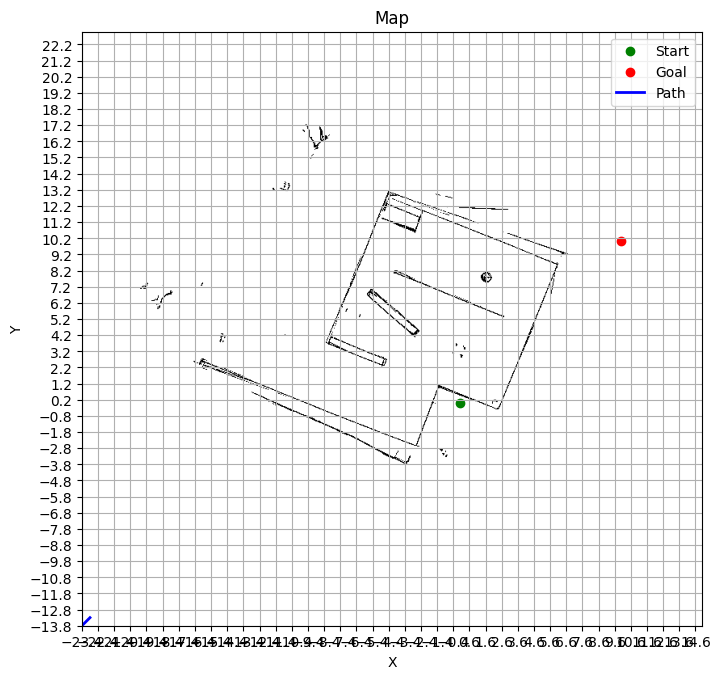

In [3]:
import numpy as np
import heapq
from PIL import Image
import matplotlib.pyplot as plt
import yaml

# Define the A* algorithm
def astar(start, goal, grid):
    # Define possible movements (up, down, left, right, diagonal)
    movements = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

    # Initialize open and closed lists
    open_list = []
    closed_set = set()

    # Create a dictionary to store the cost from start to each cell
    g_scores = {start: 0}

    # Create a dictionary to store the estimated total cost for each cell
    f_scores = {start: heuristic(start, goal)}

    # Add the start cell to the open list
    heapq.heappush(open_list, (f_scores[start], start))

    while open_list:
        _, current = heapq.heappop(open_list)

        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        closed_set.add(current)

        # Explore neighbors
        for move in movements:
            neighbor = current[0] + move[0], current[1] + move[1]

            if not is_valid(neighbor, grid) or neighbor in closed_set:
                continue

            tentative_g_score = g_scores[current] + 1

            if neighbor not in g_scores or tentative_g_score < g_scores[neighbor]:
                came_from[neighbor] = current
                g_scores[neighbor] = tentative_g_score
                f_scores[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_scores[neighbor], neighbor))

    # No path found
    return None

# Define the heuristic function (Euclidean distance)
def heuristic(a, b):
    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)

# Check if a cell is valid (within the grid boundaries and not an obstacle)
def is_valid(cell, grid):
    x, y = cell
    rows, cols = grid.shape
    return 0 <= x < rows and 0 <= y < cols and grid[x][y] == 255

# Load the YAML file
with open("base.yaml", "r") as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)

# Extract map properties from YAML
image_file = yaml_data["image"]
resolution = yaml_data["resolution"]
origin = yaml_data["origin"]
occupied_thresh = yaml_data["occupied_thresh"]
free_thresh = yaml_data["free_thresh"]

# Load the PGM file
pgm_image = Image.open(image_file)
grid = np.array(pgm_image)

# Convert grayscale to binary representation
threshold = int((occupied_thresh - free_thresh) * 255)
grid = (grid > threshold).astype(np.uint8) * 255

# Calculate grid resolution based on desired distance between grid lines
desired_distance = 1  # Adjust this value as needed
grid_resolution = resolution * int(round(desired_distance / resolution))

# Set the start and goal points
start = (0, 0)
goal = (10, 10)

# Run the A* algorithm
came_from = {}
path = astar(start, goal, grid)

if path is not None:
    print("Path found:", path)
else:
    print("No path found.")

# Visualize the map and path
plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap="gray", origin='lower', extent=[origin[0], origin[0] + resolution * grid.shape[1],
                                                      origin[1], origin[1] + resolution * grid.shape[0]])
plt.scatter(start[0], start[1], color="green", marker="o", label="Start")
plt.scatter(goal[0], goal[1], color="red", marker="o", label="Goal")

if path is not None:
    path_x = [point[0] * resolution + origin[0] for point in path]
    path_y = [point[1] * resolution + origin[1] for point in path]
    plt.plot(path_x, path_y, color="blue", linewidth=2, label="Path")

# Configure grid lines
x_ticks = np.arange(origin[0], origin[0] + resolution * grid.shape[1], grid_resolution)
y_ticks = np.arange(origin[1], origin[1] + resolution * grid.shape[0], grid_resolution)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Map")
plt.grid(True)
plt.show()